In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import math
from astropy import time, coordinates as coord, units as u
import requests
import matplotlib.dates as mdates
from pandas.plotting import table

Path to PixInsight photometry result files

In [2]:
target="W UMa"
path="D:\\Astronomie\\SharpCap Captures\\20250309\\WUma\\work\\photometry_cal"
filelist=os.listdir(path)

Get AAVSO data from target variable

In [3]:
response = requests.get(f"http://www.aavso.org/vsx/index.php?view=api.object&ident={target}&format=json")   
vsx_data=response.json()['VSXObject']
vsx_data

{'Name': 'W UMa',
 'AUID': '000-BBQ-676',
 'RA2000': '145.93946',
 'Declination2000': '55.95253',
 'ProperMotionRA': '17.2400',
 'ProperMotionDec': '-28.9100',
 'VariabilityType': 'EW/KW',
 'Period': '0.3336334',
 'Epoch': '2453761.977',
 'MaxMag': '7.75 V',
 'MinMag': '8.48 V',
 'SpectralType': 'F8Vp+F8Vp',
 'Discoverer': 'Müller and Kempf (1908)',
 'Category': 'Variable',
 'OID': '37110',
 'Constellation': 'UMa'}

In [4]:
constellation=vsx_data['Constellation']
star=vsx_data['Name']
period= vsx_data['Period']
position = coord.SkyCoord(vsx_data['RA2000'],vsx_data['Declination2000'],
                        unit=(u.deg, u.deg), frame='icrs')
observatory = coord.EarthLocation(lat=51.43, lon=6.82, height=40)

Get Photometry field from AAVSO

In [5]:
response = requests.get(f"https://www.aavso.org/vsp/api/chart/?star={star}&fov=60&maglimit=15&format=json")
chart_data=response.json()
chart_data

{'chartid': 'X40056WL',
 'image_uri': 'https://apps.aavso.org/vsp/chart/X40056WL.png?format=json',
 'star': 'W UMa',
 'fov': 60.0,
 'maglimit': 15.0,
 'title': '',
 'comment': '',
 'resolution': 150,
 'dss': False,
 'special': None,
 'photometry': [{'auid': '000-BBQ-651',
   'ra': '09:42:42.03',
   'dec': '55:39:56.3',
   'label': '89',
   'bands': [{'band': 'V', 'mag': 8.936, 'error': 0.052},
    {'band': 'B', 'mag': 9.81, 'error': 0.066},
    {'band': 'Ic', 'mag': 7.909, 'error': 0.082},
    {'band': 'J', 'mag': 7.242, 'error': 0.017},
    {'band': 'H', 'mag': 6.802, 'error': 0.011},
    {'band': 'K', 'mag': 6.71, 'error': 0.013}],
   'comments': ''},
  {'auid': '000-BBQ-747',
   'ra': '09:46:02.66',
   'dec': '55:45:00.0',
   'label': '92',
   'bands': [{'band': 'V', 'mag': 9.161, 'error': 0.049},
    {'band': 'B', 'mag': 10.342, 'error': 0.067},
    {'band': 'Ic', 'mag': 7.913, 'error': 0.076},
    {'band': 'J', 'mag': 7.118, 'error': 0.021},
    {'band': 'H', 'mag': 6.566, 'error'

In [6]:
auid_list = []
for photometry_data in chart_data['photometry']:
    auid = photometry_data['auid']
    ra=photometry_data['ra']
    dec=photometry_data['dec']
    for band_data in photometry_data['bands']:
        if band_data['band'] == 'V':
            mag = band_data['mag']
            auid_list.append((auid, ra, dec, mag))

In [7]:
auid_list

[('000-BBQ-651', '09:42:42.03', '55:39:56.3', 8.936),
 ('000-BBQ-747', '09:46:02.66', '55:45:00.0', 9.161)]

Match with PixInsight Photometry Table

In [8]:
file=filelist[0]
df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
df.columns = df.columns.str.replace(' ', '')
names= df[['NAME']].to_numpy()
catalogue= df[['CATRA', 'CATDEC']].to_numpy()
flags= df[['FLAG']].to_numpy() 
catalogue=coord.SkyCoord(catalogue[:,0],catalogue[:,1],unit=(u.deg, u.deg), frame='icrs')

In [9]:
idx,d2d,d3d=position.match_to_catalog_sky(catalogue)
varstar=names[idx][0].replace(" ", "")
varstar

'3UCAC292-105168'

In [10]:
star_data=np.array([(tup[1], tup[2]) for tup in auid_list])
star_coord=coord.SkyCoord(star_data[:,0],star_data[:,1],unit=(u.hourangle, u.deg), frame='icrs')

In [11]:
idx,d2d,d3d=star_coord.match_to_catalog_sky(catalogue)

In [12]:
d2d

<Angle [0.00076495, 0.00013752] deg>

In [13]:
df.iloc[idx]

,DATE_OBS,NAME,FILTER,CATRA,CATDEC,IMGRA,IMGDEC,IMGX,IMGY,f.mag,...,SNR10,SNR11,SNR12,SNR13,SNR14,SNR15,SNR16,SNR17,SNR18,FLAG
3,2.460738e+06,3UCAC292-105134,Johnson V,145.674761,55.664902,145.674773,55.664891,2951.724,546.943,8.493,...,563.6683,561.2961,557.6585,553.1060,547.9111,542.1847,535.9678,529.2833,522.3785,0
5,2.460738e+06,3UCAC292-105240,Johnson V,146.510994,55.749872,146.510933,55.749860,3816.494,2362.340,8.652,...,526.7523,524.1994,520.2867,515.4391,509.8366,503.6736,497.2212,490.5348,483.5300,0


In [14]:
photometry_stars=[]
photometry_mags=[]
for i in range(len(auid_list)):
    if flags[idx[i]] == 0 and d2d[i].arcsec < 10.0:
        photometry_stars.append(names[idx[i]][0].replace(" ", ""))
        photometry_mags.append(auid_list[i][3])

In [15]:
photometry_stars, photometry_mags

(['3UCAC292-105134', '3UCAC292-105240'], [8.936, 9.161])

In [16]:

check=photometry_stars[0]
compstar=photometry_stars[1:2]
compstar_mag=photometry_mags[1:2]

In [17]:
check

'3UCAC292-105134'

In [18]:
file=filelist[0]
df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
df

,DATE_OBS,NAME,FILTER,CATRA,CATDEC,IMGRA,IMGDEC,IMGX,IMGY,f.mag,...,SNR10,SNR11,SNR12,SNR13,SNR14,SNR15,SNR16,SNR17,SNR18,FLAG
0,2.460738e+06,3UCAC292-105088,Johnson V,145.319330,55.866243,145.319343,55.866250,1773.314,368.546,6.319,...,1618.0120,1629.3240,1635.9640,1640.2510,1642.5660,1643.6350,1643.6640,1642.9930,1641.5890,10
1,2.460738e+06,3UCAC292-105167,Johnson V,145.939380,55.952130,145.939679,55.952317,2341.020,1761.715,7.600,...,905.6699,907.1053,907.1953,906.1148,904.4782,902.2737,899.4543,895.9960,891.7788,1
2,2.460738e+06,3UCAC292-105168,Johnson V,145.939864,55.952429,145.939679,55.952317,2341.020,1761.715,8.324,...,905.6699,907.1053,907.1953,906.1148,904.4782,902.2737,899.4543,895.9960,891.7788,1
3,2.460738e+06,3UCAC292-105134,Johnson V,145.674761,55.664902,145.674773,55.664891,2951.724,546.943,8.493,...,563.6683,561.2961,557.6585,553.1060,547.9111,542.1847,535.9678,529.2833,522.3785,0
4,2.460738e+06,3UCAC293-109009,Johnson V,145.621195,56.187249,145.621198,56.187244,1103.791,1736.571,8.507,...,579.6421,577.5769,574.0035,569.5864,564.3983,558.7005,552.5244,545.9447,539.0845,0
5,2.460738e+06,3UCAC292-105240,Johnson V,146.510994,55.749872,146.510933,55.749860,3816.494,2362.340,8.652,...,526.7523,524.1994,520.2867,515.4391,509.8366,503.6736,497.2212,490.5348,483.5300,0
6,2.460738e+06,3UCAC292-105289,Johnson V,146.803479,55.812654,146.803463,55.812636,4000.487,3079.550,9.535,...,346.6649,341.7445,336.0460,329.8223,323.0915,316.1596,309.1477,302.2858,295.3399,0


In [19]:
t0=df.iloc[0,0]
t0_iso=time.Time(t0,format="jd")

In [20]:
l=[]
for s in df.iloc[:,1]: l=l+[s.strip()]
df.iloc[:,1]=l

In [38]:
def plot_flux_vs_aperture(file_index, filelist, target, path):
    """
    Plots normalized flux values against aperture sizes for a specific target star.
    Flux values are normalized so that the maximum value equals 1.
    
    Parameters:
    - file_index: Index of the file in filelist to analyze
    - filelist: List of photometry files
    - target: Name of the target star
    - path: Path to the directory containing the files
    """
    import re
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get the file at the specified index
    file = filelist[file_index]
    
    # Read the file
    df = pd.read_csv(path + "\\" + file, sep=";", skiprows=5)
    
    # Clean star names
    l = []
    for s in df.iloc[:, 1]:
        l.append(s.strip())
    df.iloc[:, 1] = l
    
    # Find the target star
    itarget = (df.iloc[:, 1] == target)
    target_data = df.loc[itarget]
    
    if len(target_data) == 0:
        print(f"Target star '{target}' not found in file {file}")
        return None, None
    
    # Clean column names and find columns that contain "FLUX" followed by digits
    flux_columns = []
    for col in df.columns:
        col_clean = col.strip()
        if re.search(r'FLUX\s*\d+', col_clean):
            flux_columns.append(col)
    
    if len(flux_columns) == 0:
        print(f"No 'FLUX' columns found in file {file}")
        return None, None
    
    # Extract aperture sizes and corresponding flux values
    aperture_sizes = []
    flux_values = []
    
    for col in flux_columns:
        # Extract the aperture size (nn) using regex
        match = re.search(r'FLUX\s*(\d+)', col.strip())
        if match:
            aperture_size = int(match.group(1))
            flux_value = target_data[col].values[0]
            
            aperture_sizes.append(aperture_size)
            flux_values.append(flux_value)
    
    # Sort by aperture size
    sorted_indices = np.argsort(aperture_sizes)
    aperture_sizes = [aperture_sizes[i] for i in sorted_indices]
    flux_values = [flux_values[i] for i in sorted_indices]
    
    # Normalize flux values so maximum equals 1
    max_flux = max(flux_values)
    normalized_flux = [flux / max_flux for flux in flux_values]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(aperture_sizes, normalized_flux, 'o-', markersize=8)
    plt.xlabel('Aperture Size (pixels)')
    plt.ylabel('Normalized Flux (max=1)')
    plt.title(f'Normalized Flux vs. Aperture Size for {target} in {file}')
    plt.grid(True)
    
    # Add file information and max flux value
    plt.annotate(f"File: {file}\nMax flux: {max_flux:.2f}", xy=(0.02, 0.98), 
                 xycoords='axes fraction', verticalalignment='top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Return the original aperture sizes and flux values
    return aperture_sizes, flux_values

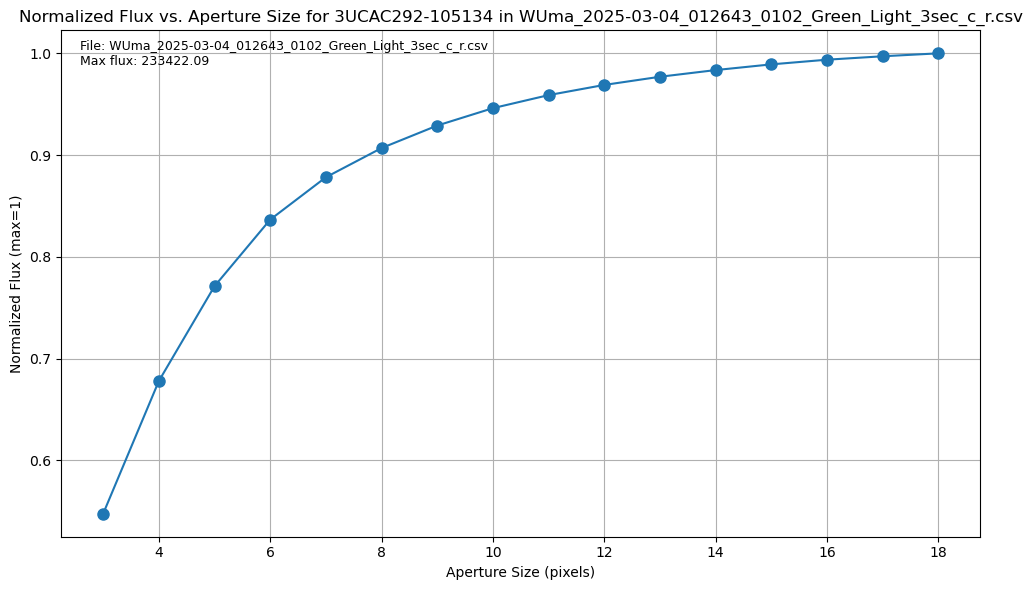

In [50]:
aperture_sizes, flux_values = plot_flux_vs_aperture(100, filelist, check, path)

In [52]:
def plot_all_growth_curves(filelist, target, path):
    """
    Plots normalized growth curves (flux vs aperture size) for all files in filelist.
    Colors points based on file index.
    
    Parameters:
    - filelist: List of photometry files
    - target: Name of the target star
    - path: Path to the directory containing the files
    """
    import re
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.cm import get_cmap
    from matplotlib.colors import Normalize
    
    plt.figure(figsize=(12, 8))
    cmap = get_cmap('viridis')  # Farbskala auswählen
    norm = Normalize(vmin=0, vmax=len(filelist)-1)  # Normalisierung für Indizes
    
    # Für die Sammlung aller Aperture-Größen zur Bestimmung der x-Achsengrenzen
    all_aperture_sizes = []
    
    # Zähler für erfolgreich verarbeitete Dateien
    valid_files = 0
    
    # Alle Dateien durchlaufen
    for i, file in enumerate(filelist):
        try:
            # Datei einlesen
            df = pd.read_csv(path + "\\" + file, sep=";", skiprows=5)
            
            # Sternnamen bereinigen
            l = []
            for s in df.iloc[:, 1]:
                l.append(s.strip())
            df.iloc[:, 1] = l
            
            # Zielstern finden
            itarget = (df.iloc[:, 1] == target)
            target_data = df.loc[itarget]
            
            if len(target_data) == 0:
                continue  # Dateien überspringen, in denen der Zielstern nicht gefunden wurde
            
            # FLUX-Spalten finden
            flux_columns = []
            for col in df.columns:
                col_clean = col.strip()
                if re.search(r'FLUX\s*\d+', col_clean):
                    flux_columns.append(col)
            
            if not flux_columns:
                continue  # Dateien ohne FLUX-Spalten überspringen
            
            # Aperture-Größen und Flux-Werte extrahieren
            aperture_sizes = []
            flux_values = []
            
            for col in flux_columns:
                match = re.search(r'FLUX\s*(\d+)', col.strip())
                if match:
                    aperture_size = int(match.group(1))
                    flux_value = target_data[col].values[0]
                    
                    aperture_sizes.append(aperture_size)
                    flux_values.append(flux_value)
            
            if not aperture_sizes:  # Überspringen, wenn keine gültigen Aperture-Größen gefunden wurden
                continue
                
            # Nach Aperture-Größe sortieren
            sorted_indices = np.argsort(aperture_sizes)
            aperture_sizes = [aperture_sizes[j] for j in sorted_indices]
            flux_values = [flux_values[j] for j in sorted_indices]
            
            all_aperture_sizes.extend(aperture_sizes)
            
            # Flux-Werte normalisieren (Maximum = 1)
            max_flux = max(flux_values)
            normalized_flux = [flux / max_flux for flux in flux_values]
            
            # Plotten mit Farbe basierend auf dem Dateiindex
            color = cmap(norm(i))
            plt.plot(aperture_sizes, normalized_flux, 'o-', color=color, alpha=0.7, 
                     linewidth=1, markersize=4)
            
            valid_files += 1
            
        except Exception as e:
            print(f"Fehler bei der Verarbeitung von Datei {file}: {e}")
            continue
    
    # Plot-Details setzen
    plt.xlabel('Aperture-Größe (Pixel)')
    plt.ylabel('Normalisierter Flux (max=1)')
    plt.title(f'Normalisierte Wachstumskurven für {target} - Alle Dateien ({valid_files} Kurven)')
    plt.grid(True, alpha=0.3)
    
    # Farbskala hinzufügen
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Datei-Index')
    
    # Sinnvolle x-Achsengrenzen setzen, wenn Daten vorhanden sind
    if all_aperture_sizes:
        min_aperture = min(all_aperture_sizes)
        max_aperture = max(all_aperture_sizes)
        plt.xlim(min_aperture-1, max_aperture+1)
    
    plt.ylim(0, 1.05)  # y-Achse bei 0 beginnen und etwas Platz über 1 lassen
    plt.tight_layout()
    plt.show()
    
    return valid_files

C:\Users\User\AppData\Local\Temp\ipykernel_16856\872075286.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')  # Farbskala auswählen
C:\Users\User\AppData\Local\Temp\ipykernel_16856\872075286.py:103: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


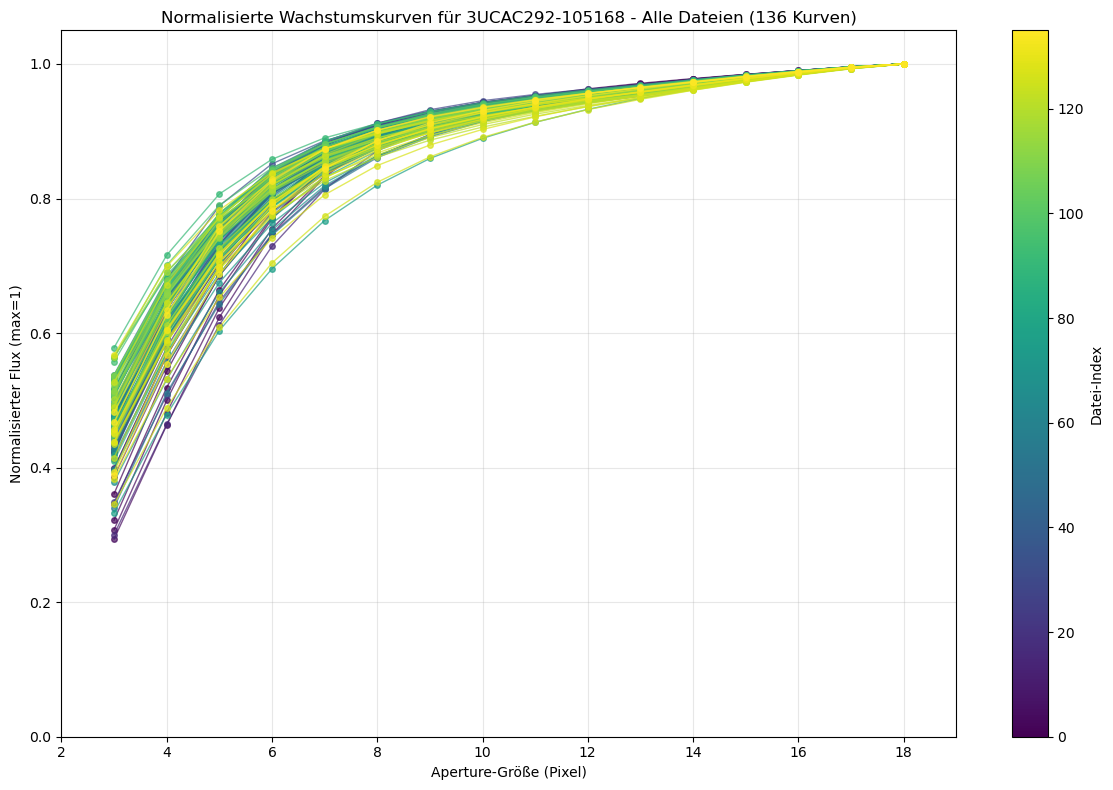

Es wurden 136 Wachstumskurven geplottet.


In [54]:
# Alle Wachstumskurven plotten
num_plotted = plot_all_growth_curves(filelist, varstar, path)
print(f"Es wurden {num_plotted} Wachstumskurven geplottet.")

In [55]:
def fluxcalc2(target, infiles, aperture_size):
    """
    Extracts flux data for a target star using the specified aperture size.
    
    Parameters:
    - target: Name of the target star
    - infiles: List of photometry files to process
    - aperture_size: Aperture size (NN) to use for flux extraction
    
    Returns:
    - DataFrame with DATE_OBS and FLUX columns
    """
    import re
    
    target_flux = pd.DataFrame()
    
    for file in infiles:
        # Read file
        df = pd.read_csv(path + "\\" + file, sep=";", skiprows=5)
        
        # Find target star
        l = []
        for s in df.iloc[:, 1]: 
            l.append(s.strip())
        df.iloc[:, 1] = l
        itarget = (df.iloc[:, 1] == target)
        
        if sum(itarget) == 0:  # Skip if target not found
            continue
            
        # Find the FLUX column with the specified aperture size
        flux_column = None
        pattern = re.compile(r'^\s*FLUX\s*' + str(aperture_size) + r'\s*$')
        
        for col in df.columns:
            if pattern.match(col):
                flux_column = col
                break
        
        if flux_column is None:  # Skip if no matching flux column
            print(f"Warning: No FLUX{aperture_size} column found in {file}")
            continue
            
        # Read flux and date
        try:
            # Find date column (allowing for whitespace)
            date_column = None
            for col in df.columns:
                if col.strip() == "DATE_OBS":
                    date_column = col
                    break
            
            if date_column is None:
                # Try with common variations
                for col in df.columns:
                    if "DATE_OBS" in col.strip():
                        date_column = col
                        break
            
            if date_column is None:
                print(f"Warning: No DATE_OBS column found in {file}")
                continue
                
            # Extract flux data
            flux_data = df.loc[itarget][[date_column, flux_column]].copy()
            flux_data = flux_data.rename(columns={date_column: "DATE_OBS", flux_column: "FLUX"})
            target_flux = pd.concat([target_flux, flux_data])
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue
    
    target_flux = target_flux.reset_index(drop=True)
    return target_flux

In [105]:
minind=0
maxind=len(filelist)
aperture=18

In [106]:
flux_var=fluxcalc2(varstar,filelist,aperture)
flux_check=fluxcalc2(check,filelist,aperture)

In [107]:
flux_comp=pd.DataFrame()
flux_comp["DATE_OBS"]=flux_var["DATE_OBS"]
flux_comp=flux_comp.reset_index(drop=True)
for star in compstar:
    flux=fluxcalc2(star,filelist,aperture)
    #flux = flux.reset_index(drop=True)
    flux_comp[star]=flux['FLUX']
print(flux_comp)   

         DATE_OBS  3UCAC292-105240
0    2.460738e+06        331301.41
1    2.460738e+06        345081.44
2    2.460738e+06        357553.19
3    2.460738e+06        347682.54
4    2.460738e+06        349360.56
..            ...              ...
131  2.460739e+06        177075.67
132  2.460739e+06        181651.74
133  2.460739e+06        182830.92
134  2.460739e+06        178197.48
135  2.460739e+06        175476.97

[136 rows x 2 columns]


In [108]:
t=flux_var.to_numpy()[minind:maxind,0]
mag_var=flux_var.to_numpy()[minind:maxind,1]
mag_check=flux_check.to_numpy()[minind:maxind,1]
mag_comp=flux_comp.to_numpy()[minind:maxind,1:]

In [109]:
nstars = mag_comp.shape[1]+2
nstars

3

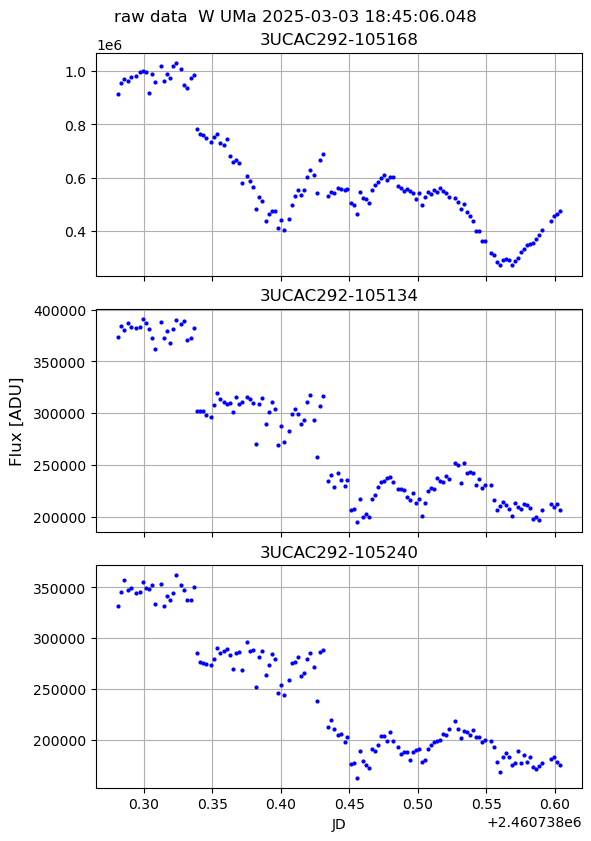

In [110]:
fig, ax = plt.subplots(nstars,1,figsize=(5.8,8.3), layout='constrained')
fig.suptitle("raw data " + " " + target + " " + t0_iso.iso )
fig.supylabel("Flux [ADU]")
ax[0].plot(t,mag_var,"bo",ms=2)
ax[0].set_title(varstar)
ax[0].tick_params(axis="x",labelbottom=False)
ax[0].grid(visible="true")
ax[1].plot(t,mag_check,"bo",ms=2)
ax[1].set_title(check)
ax[1].grid(visible="true")
ax[1].tick_params(axis="x",labelbottom=False)
for i in range(2,nstars):
    ax[i].plot(t,mag_comp[:,i-2],"bo",ms=2)
    ax[i].set_title(compstar[i-2])
    ax[i].grid(visible="true")
    ax[i].tick_params(axis="x",labelbottom=False)
ax[nstars-1].set_xlabel("JD")
ax[nstars-1].tick_params(axis="x",labelbottom=True)

fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_iso.to_value("jd")-2400000)+"_"+"RAW_DATA"+".pdf", format="pdf")

In [111]:
# Create a new DataFrame with the same column names as flux_comp
mag_var = pd.DataFrame({'DATE_OBS': flux_comp['DATE_OBS']})

# Calculate the new columns
for star, mag0 in zip(compstar, compstar_mag):
    mag_var[star] = -2.5 * np.log10(flux_var['FLUX'] / flux_comp[star]) + mag0

print(mag_var)

         DATE_OBS  3UCAC292-105240
0    2.460738e+06         8.057638
1    2.460738e+06         8.056958
2    2.460738e+06         8.076936
3    2.460738e+06         8.055737
4    2.460738e+06         8.044146
..            ...              ...
131  2.460739e+06         8.261493
132  2.460739e+06         8.204377
133  2.460739e+06         8.162962
134  2.460739e+06         8.117662
135  2.460739e+06         8.079517

[136 rows x 2 columns]


In [112]:
# Identify the columns to be averaged (all columns except 'date_obs')
columns_to_average = mag_var.columns.difference(['DATE_OBS'])

# Calculate the row-wise mean for these columns
mag_var['average'] = mag_var[columns_to_average].mean(axis=1)

mag_var

,DATE_OBS,3UCAC292-105240,average
0,2.460738e+06,8.057638,8.057638
1,2.460738e+06,8.056958,8.056958
2,2.460738e+06,8.076936,8.076936
3,2.460738e+06,8.055737,8.055737
4,2.460738e+06,8.044146,8.044146
...,...,...,...
131,2.460739e+06,8.261493,8.261493
132,2.460739e+06,8.204377,8.204377
133,2.460739e+06,8.162962,8.162962
134,2.460739e+06,8.117662,8.117662


In [113]:
mag = mag_var['average'].to_numpy()
mag.shape

(136,)

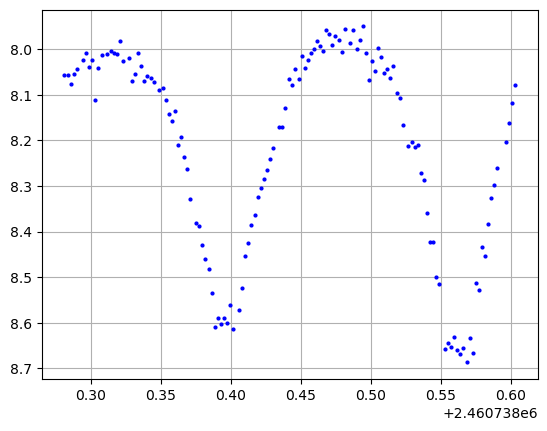

In [114]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(t,mag,"bo",ms=2)  # Plot some data on the axes.
#ax.set_ylim(12.7,12.8)
ax.invert_yaxis()
ax.grid(visible=True)

In [115]:
# Create a new DataFrame with the same column names as flux_comp
mag_check = pd.DataFrame({'DATE_OBS': flux_comp['DATE_OBS']})

# Calculate the new columns
for star, mag0 in zip(compstar, compstar_mag):
    mag_check[star] = -2.5 * np.log10(flux_check['FLUX'] / flux_comp[star]) + mag0

print(mag_check)

         DATE_OBS  3UCAC292-105240
0    2.460738e+06         9.030102
1    2.460738e+06         9.043464
2    2.460738e+06         9.094061
3    2.460738e+06         9.043640
4    2.460738e+06         9.060786
..            ...              ...
131  2.460739e+06         8.991728
132  2.460739e+06         8.989667
133  2.460739e+06         9.012514
134  2.460739e+06         8.970147
135  2.460739e+06         8.984056

[136 rows x 2 columns]


In [116]:
# Identify the columns to be averaged (all columns except 'date_obs')
columns_to_average = mag_check.columns.difference(['DATE_OBS'])

# Calculate the row-wise mean for these columns
mag_check['average'] = mag_check[columns_to_average].mean(axis=1)

mag_check

,DATE_OBS,3UCAC292-105240,average
0,2.460738e+06,9.030102,9.030102
1,2.460738e+06,9.043464,9.043464
2,2.460738e+06,9.094061,9.094061
3,2.460738e+06,9.043640,9.043640
4,2.460738e+06,9.060786,9.060786
...,...,...,...
131,2.460739e+06,8.991728,8.991728
132,2.460739e+06,8.989667,8.989667
133,2.460739e+06,9.012514,9.012514
134,2.460739e+06,8.970147,8.970147


In [117]:
mag_c = mag_check['average'].to_numpy()
mag.shape

(136,)

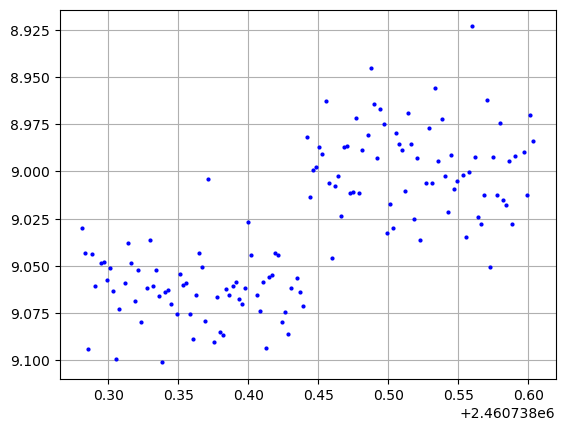

In [118]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(t,mag_c,"bo",ms=2)  # Plot some data on the axes.
ax.grid(visible=True)
#ax.set_ylim(12.4,12.5)
ax.invert_yaxis()

In [119]:
err_c=np.std(mag_c)
err_c

0.03867595179630593

In [44]:
lc=np.empty((mag.shape[0],3))
lc[:,0]=t
lc[:,1]=mag
lc[:,2]=err_c

In [45]:
t0=int(lc[0,0])
t=lc[:,0]-t0
mag=lc[:,1]
merr=lc[:,2]

In [46]:
t0_ap=time.Time(t0,format="jd")
t0_ap.to_value("iso",subfmt="date")

'2025-03-03'

In [47]:
p=float(period)
w=2*math.pi/p
k=8
C=np.stack([np.sin(i*w*t) for i in range(1,k+1)])
B=np.stack([np.cos(i*w*t) for i in range(k+1)])
A=np.concatenate((B,C)).T
coeff = np.linalg.lstsq(A,mag,rcond=None)[0]

In [48]:
def lc_fourier(t,w,coeff):
    n=coeff.shape[0]
    mag=0
    k=int((n-1)/2)
    for i in range(0,k+1):
        mag=mag+coeff[i]*np.cos(i*w*t)
    for i in range(k+1,n):
        mag=mag+coeff[i]*np.sin((i-k)*w*t)
    return mag

In [49]:
t_step=np.linspace(min(t),max(t),1000)

In [50]:
x=lc_fourier(t_step,w,coeff)

In [51]:
ind=sp.signal.argrelmin(x)
ind1=sp.signal.argrelmax(x)

In [52]:
ind1

(array([106, 362, 875], dtype=int64),)

In [53]:
t0_ap=time.Time(t0+t_step[ind],format="jd")
t1_ap=time.Time(t0+t_step[ind1],format="jd")
t0_ap.to_value("iso")

array(['2025-03-03 19:22:06.256', '2025-03-03 19:48:16.872',
       '2025-03-03 23:16:45.701'], dtype='<U23')

In [54]:
t0_ap = time.Time(t0+t_step[ind],format="jd",
                  scale='utc', location=observatory)  
t1_ap=time.Time(t0+t_step[ind1],format="jd",
                  scale="utc",location=observatory)
ltt0_helio = t0_ap.light_travel_time(position,"heliocentric") 
ltt1_helio = t1_ap.light_travel_time(position,"heliocentric") 
ltt0_helio.to_value("jd") 

array([0.00356832, 0.00356751, 0.00356103])

In [55]:
time.Time(t0+t_step[ind],format="jd",
                  scale='utc', location=observatory)  

<Time object: scale='utc' format='jd' value=[2460738.30701686 2460738.32519528 2460738.46997339]>

In [56]:
t_am=time.Time(t0+t_step,format="jd",scale="utc",location=observatory)
frame=coord.AltAz(obstime=t_am,location=observatory)
airmass=position.transform_to(frame).secz
[airmass[0],airmass[999],np.min(airmass)]

[<Quantity 1.19607113>, <Quantity 1.21470464>, <Quantity 1.00296598>]

In [57]:
description=[["Maximum (UTC, geocentric)",t0_ap[0].to_value("iso")],
             ["Maximum (HJD, time base UTC)",'%-8.4f'%(t0_ap[0].to_value("jd")+ltt0_helio[0].to_value("jd"))+"+/-0.002"],
             ["Maximum (UTC, geocentric)",t0_ap[1].to_value("iso")],
             ["Maximum (HJD, time base UTC)",'%-8.4f'%(t0_ap[1].to_value("jd")+ltt0_helio[1].to_value("jd"))+"+/-0.002"],
             ["Minimum (UTC, geocentric)",t1_ap[0].to_value("iso")],
             ["Minimim (HJD, time base UTC)",'%-8.4f'%(t1_ap[0].to_value("jd")+ltt1_helio[0].to_value("jd"))+"+/-0.002"],
             ["Minimum (UTC, geocentric)",t1_ap[1].to_value("iso")],
             ["Minimim (HJD, time base UTC)",'%-8.4f'%(t1_ap[1].to_value("jd")+ltt1_helio[1].to_value("jd"))+"+/-0.002"],
             ["Observer","Deeskow, DES"],
             ["Instrumnent","CFF140 f/6.6, ASI1600mm with V Filter"],
             ["Comparison Star",compstar[0]],
             ["",compstar[1]],
             ["",compstar[2]],
             ["Photometry","PixInsight Photometry Skript"],
             ["Evaluation","Fourier-Fit"],
             ["Airmass","1.072 ... 1.028 ... 1.174"],
             ["Number of Measurements",str(lc.shape[0])]
            ]
title=target + " " + "             "+t0_ap[0].to_value("iso",subfmt="date")

IndexError: list index out of range

In [58]:
tiso=time.Time(t0+t,format="jd")
t_step_iso=time.Time(t0+t_step,format="jd")
jd0=t_step_iso[0].jd

In [59]:
mpl0=mpl.dates.date2num(t_step_iso[0].datetime)

In [60]:
def jd2mpl(tin):
    tout=tin+mpl0-jd0-ltt0_helio[0].to_value("jd")+int(jd0)
    return tout

In [61]:
def mpl2jd(tin):
    tout=tin-mpl0+jd0+ltt0_helio[0].to_value("jd")-int(jd0) 
    return tout

NameError: name 'title' is not defined

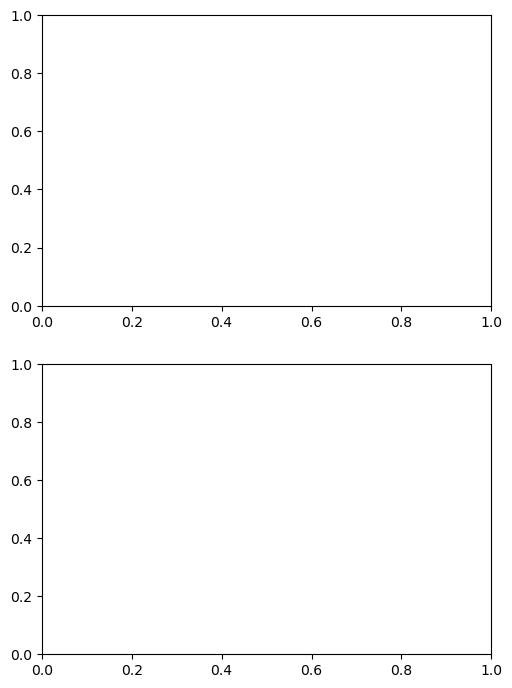

In [62]:
fig, (ax,ax1) = plt.subplots(2,1,height_ratios=[1,1],figsize=(5.8,8.3))
fig.suptitle(title,x=0.5,y=0.97,ha="center")
ax.clear()
ax.errorbar(tiso.datetime,mag,yerr=merr,elinewidth=0.5,marker="o",ms=2,linestyle="none")
ax.plot(t_step_iso.datetime,lc_fourier(t_step,w,coeff),"b--",linewidth=1)  
for i in ind[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
for i in ind1[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
ax.invert_yaxis()
ax.minorticks_on()
ax.grid(visible=True,which="both")
ax.set_xlabel("UTC")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.set_xlabel("JD "+'%-8.0f'%(int(t0_ap.to_value("jd"))))
ax.set_ylabel("Magnitude")

secax = ax.secondary_xaxis('top', functions=(mpl2jd,jd2mpl))
secax.set_xlabel('HJD'+" "+str(int(jd0))+" +")
#pticks=ax.get_xticks()
#secax.set_xticks(mpl2jd(pticks))
secax.minorticks_on()

ax1.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False)
ax1.set_axis_off()
ax1.table(description,loc="upper center",cellLoc="left",edges="")

fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[1].jd-2400000+ltt0_helio[1].to_value("jd"))+"_"+"DES"+".pdf", format="pdf")
    

NameError: name 'title' is not defined

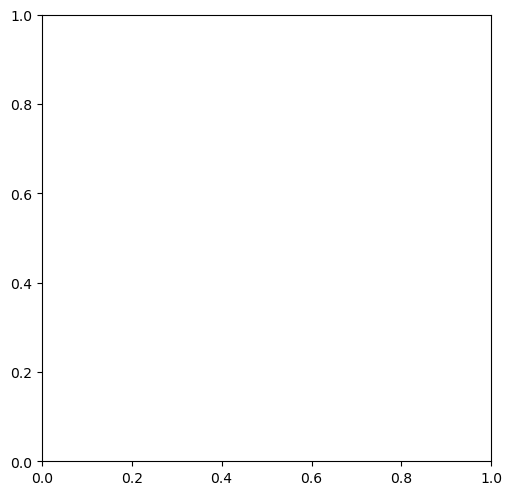

In [63]:
fig, ax = plt.subplots(1,1,height_ratios=[1],figsize=(5.8,5.8))
fig.suptitle(title,x=0.5,y=0.97,ha="center")
ax.clear()
ax.errorbar(tiso.datetime,mag,yerr=merr,elinewidth=0.5,marker="o",ms=2,linestyle="none")
ax.plot(t_step_iso.datetime,lc_fourier(t_step,w,coeff),"b--",linewidth=1)  
for i in ind[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
for i in ind1[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
ax.invert_yaxis()
ax.minorticks_on()
ax.grid(visible=True,which="both")
ax.set_xlabel("UTC")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.set_xlabel("JD "+'%-8.0f'%(int(t0_ap.to_value("jd"))))
ax.set_ylabel("Magnitude")

secax = ax.secondary_xaxis('top', functions=(mpl2jd,jd2mpl))
secax.set_xlabel('HJD'+" "+str(int(jd0))+" +")
#pticks=ax.get_xticks()
#secax.set_xticks(mpl2jd(pticks))
secax.minorticks_on()


fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[1].jd-2400000+ltt0_helio[1].to_value("jd"))+"_"+"DES"+".png", format="png")
    

In [84]:
maxlist=[]
for i in range(t0_ap.shape[0]): 
    maximum=[constellation,
         target.replace(constellation, ""),
         "max",
         '%-8.4f'%(t0_ap[i].to_value("jd")),
         '%-8.4f'%(t0_ap[i].to_value("jd")+ltt0_helio[i].to_value("jd")),
         '0.002',
         "na",
         "na",
         '%-6.3f'%(lc_fourier(t0_ap[i].jd-t0,w,coeff)),
         "C",
         "ASI1600MM",
         "V",
         str(lc.shape[0]),
         "DES",
         "na"
        ]
    maxout=""
    for entry in maximum:
        maxout=maxout+entry+"|"
    maxlist=maxlist+[maxout]   
        
maxlist

['Cep|RZ |max|2460574.4873|2460574.4896|0.002|na|na|9.205 |C|ASI1600MM|V|302|DES|na|',
 'Cep|RZ |max|2460574.5164|2460574.5186|0.002|na|na|9.182 |C|ASI1600MM|V|302|DES|na|']

In [85]:
minlist=[]
for i in range(t1_ap.shape[0]):
    minimum=[constellation,
         target.replace(constellation, ""),
         "min",
         '%-8.4f'%(t1_ap[i].to_value("jd")),
         '%-8.4f'%(t1_ap[i].to_value("jd")+ltt1_helio[i].to_value("jd")),
         '0.002',
         "na",
         "na",
         '%-6.3f'%(lc_fourier(t1_ap[i].jd-t0,w,coeff)),
         "C",
         "ASI1600MM",
         "V",
         str(lc.shape[0]),
         "DES",
         "na"
        ]
    minout=""
    for entry in minimum:
        minout=minout+entry+"|"
    minlist=minlist+[minout]  
minlist

['Cep|RZ |min|2460574.3900|2460574.3923|0.002|na|na|9.720 |C|ASI1600MM|V|302|DES|na|',
 'Cep|RZ |min|2460574.4954|2460574.4977|0.002|na|na|9.207 |C|ASI1600MM|V|302|DES|na|']

In [86]:
f=open(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[i].jd-2400000+ltt0_helio[i].to_value("jd"))+"_"+"DES"+"_MiniMax"+".txt","w")
f.write("#TYPE=BAVMiniMax")
f.write("\n")
f.write("#Delim=|")
f.write("\n")
for line in maxlist:
    f.write(line)
    f.write("\n")
for line in minlist:
    f.write(line)
    f.write("\n")
f.close()

In [87]:
np.savetxt(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[0].jd-2400000+ltt0_helio[0].to_value("jd"))+"_"+"DES"+"_BAVReport"+".txt",lc,fmt="%-8.4f",header="BAV-Report"+"\n"+"Rem=")

In [88]:
data=np.array([(2442635.374,2448500.0334,2454388.5221,2454388.0832),(0.30864291,0.3086876,0.308626840,0.30862741)])
data=np.transpose(data)

In [89]:
data=np.array([(2442635.374,2448500.0334,2446342.6620,2454388.0832),(0.30864291,0.3086876,0.30868420,0.30862741)])
data=np.transpose(data)

In [90]:
elements=pd.DataFrame(data,columns=["epoch","period"],index=["AAVSO","GCVS","BAV","DES"])

In [91]:
elements

,epoch,period
AAVSO,2.442635e+06,0.308643
GCVS,2.448500e+06,0.308688
BAV,2.446343e+06,0.308684
DES,2.454388e+06,0.308627


In [92]:
tmax=(t0_ap[1].to_value("jd")+ltt0_helio[1].to_value("jd"))

In [93]:
oc=pd.DataFrame(data=None,index=["AAVSO","GCVS","BAV","DES"],columns=["O-C"])
for dataset in elements.itertuples():
    e=int((tmax-dataset.epoch)/dataset.period)
    oc0=tmax-(dataset.epoch+e*dataset.period)
    oc1=tmax-(dataset.epoch+(e+1)*dataset.period)
    if abs(oc0) < abs(oc1):
        oc.loc[dataset.Index]["O-C"]=oc0
    else:
        oc.loc[dataset.Index]["O-C"]=oc1
oc

,O-C
AAVSO,-0.107208
GCVS,-0.138912
BAV,-0.028391
DES,-0.000984


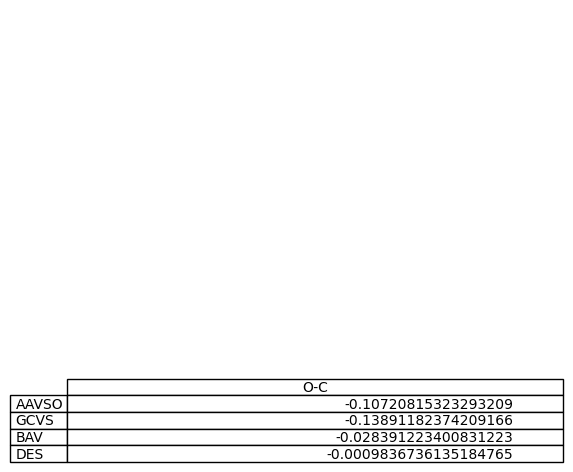

In [94]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, oc)  # where df is your data frame

plt.show()

In [ ]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.
